📁 Fase 1 – Creación de carpetas
✅ Carpetas creadas correctamente.

📄 Fase 2 – Creación del archivo base.csv
ℹ️ El archivo base.csv ya existe.

🧮 Fase 3 – Generación de datos aleatorios (pacientes.csv)
✅ Archivo pacientes.csv creado.

🧹 Fase 4 – Limpieza de Datos
✅ Datos limpios guardados en database/pacientes_clean.csv

🗄️ Fase 5 – Carga en MongoDB
✅ Datos cargados correctamente en MongoDB.

📊 Fase 6 – Visualización de Datos


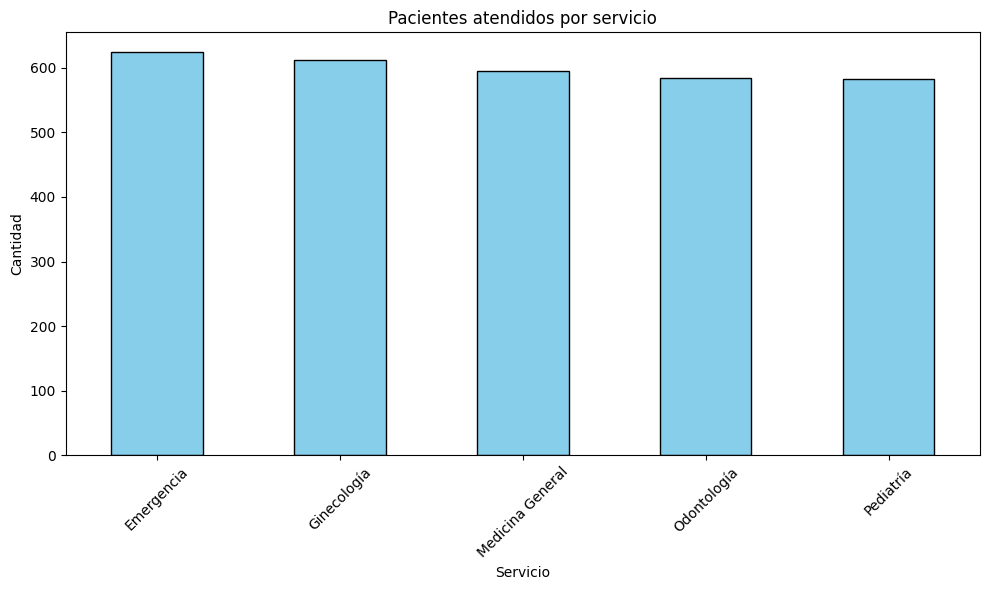

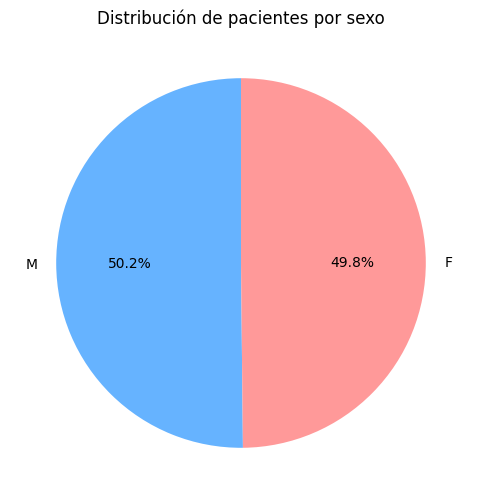

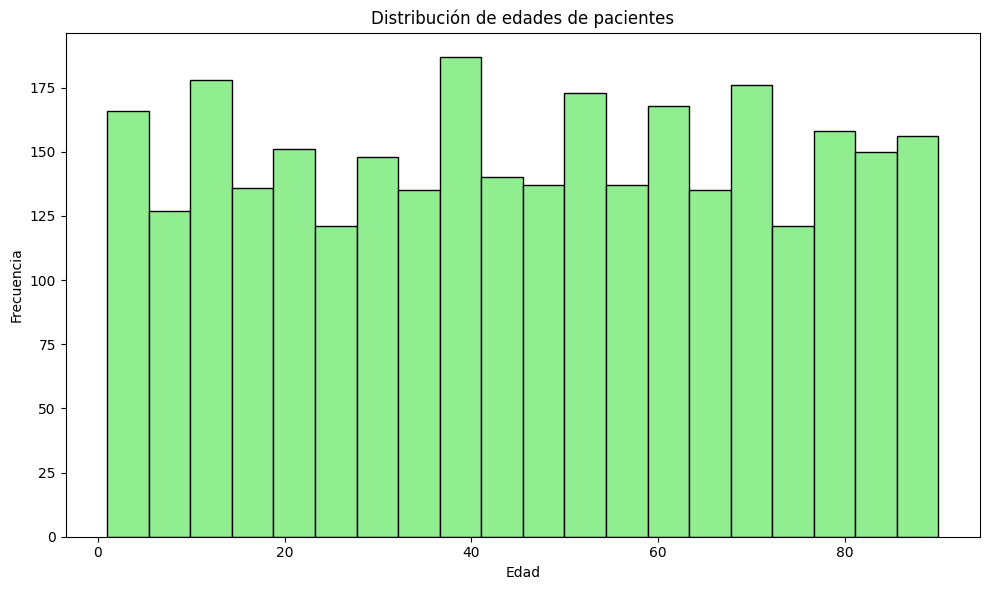


📋 Promedio de montos por distrito:
   distrito      monto
San Ignacio 281.962888
       Jaén 280.883102
    Cutervo 278.164842
  Cajamarca 274.282525
      Chota 271.834900


In [1]:
# ============================================================
# 🧩 PROYECTO: Sistema ETL + Visualización - SaludDigital_2025
# Autor: Frank Ernesto
# ============================================================

# Importar librerías necesarias
import os
from pathlib import Path
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pymongo import MongoClient

# ============================================================
# FASE 1 – CREACIÓN DE ESTRUCTURA DE CARPETAS
# ============================================================
print("📁 Fase 1 – Creación de carpetas")

base_path = Path.cwd()
folders = ["data", "database", "reports", "ci", "git", "scripts"]

for folder in folders:
    path = base_path / folder
    path.mkdir(parents=True, exist_ok=True)

print("✅ Carpetas creadas correctamente.\n")

# ============================================================
# FASE 2 – DEFINICIÓN DE ESQUEMA
# ============================================================
print("📄 Fase 2 – Creación del archivo base.csv")

data_path = base_path / "data"
archivo_base = data_path / "base.csv"

if not archivo_base.exists():
    with open(archivo_base, "w", encoding="utf-8") as f:
        f.write("Num_Cta,Cli_Codigo,TipoCuenta,Sucursal,FechaApertura,Saldo\n")
    print("✅ Archivo base.csv creado.")
else:
    print("ℹ️ El archivo base.csv ya existe.\n")

# ============================================================
# FASE 3 – GENERACIÓN DE DATOS ALEATORIOS
# ============================================================
print("🧮 Fase 3 – Generación de datos aleatorios (pacientes.csv)")

n = 3000
servicios = ["Emergencia", "Pediatría", "Ginecología", "Medicina General", "Odontología"]
sexos = ["M", "F"]
distritos = ["Jaén", "Cajamarca", "Chota", "Cutervo", "San Ignacio"]
transportes = ["Ambulancia", "Particular", "NA", None]

def random_date():
    start = datetime(2023, 1, 1)
    end = datetime(2025, 10, 1)
    return start + timedelta(days=random.randint(0, (end - start).days))

data = {
    "id_paciente": range(1, n + 1),
    "nombre": [f"Paciente_{i}" for i in range(1, n + 1)],
    "sexo": [random.choice(sexos) for _ in range(n)],
    "edad": [random.randint(1, 90) for _ in range(n)],
    "servicio": [random.choice(servicios) for _ in range(n)],
    "distrito": [random.choice(distritos) for _ in range(n)],
    "fecha_atencion": [random_date().strftime("%Y-%m-%d") for _ in range(n)],
    "transporte": [random.choice(transportes) for _ in range(n)],
    "monto": [round(random.uniform(50, 500), 2) for _ in range(n)]
}

df = pd.DataFrame(data)

pacientes_csv = data_path / "pacientes.csv"
df.to_csv(pacientes_csv, index=False, encoding="utf-8")
print("✅ Archivo pacientes.csv creado.\n")

# ============================================================
# FASE 4 – ETL (Limpieza de Datos)
# ============================================================
print("🧹 Fase 4 – Limpieza de Datos")

# Leer archivo original
df = pd.read_csv(pacientes_csv)

# Eliminar duplicados
df = df.drop_duplicates()

# Rellenar valores nulos en transporte y otros campos
df["transporte"] = df["transporte"].fillna("Desconocido").replace("NA", "Desconocido")

# Formatear fechas
df["fecha_atencion"] = pd.to_datetime(df["fecha_atencion"], errors="coerce").dt.strftime("%Y-%m-%d")

# Validar tipos de datos
df["edad"] = df["edad"].astype(int)
df["monto"] = df["monto"].astype(float)

# Guardar archivo limpio
database_path = base_path / "database"
archivo_clean = database_path / "pacientes_clean.csv"
df.to_csv(archivo_clean, index=False, encoding="utf-8")

print("✅ Datos limpios guardados en database/pacientes_clean.csv\n")

# ============================================================
# FASE 5 – CARGA EN MONGODB
# ============================================================
print("🗄️ Fase 5 – Carga en MongoDB")

try:
    client = MongoClient("mongodb://localhost:27017/")
    db = client["SaludDigital_2025"]
    coleccion = db["pacientes"]

    # Eliminar colección previa (opcional)
    coleccion.delete_many({})

    # Insertar registros
    registros = df.to_dict("records")
    coleccion.insert_many(registros)

    print("✅ Datos cargados correctamente en MongoDB.\n")

except Exception as e:
    print("⚠️ No se pudo conectar o insertar en MongoDB:", e, "\n")

# ============================================================
# FASE 6 – VISUALIZACIÓN DE DATOS
# ============================================================
print("📊 Fase 6 – Visualización de Datos")

# Gráfico de barras: pacientes por servicio
plt.figure(figsize=(10, 6))
df["servicio"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Pacientes atendidos por servicio")
plt.xlabel("Servicio")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico circular: distribución por sexo
plt.figure(figsize=(6, 6))
df["sexo"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=["#66b3ff", "#ff9999"])
plt.title("Distribución de pacientes por sexo")
plt.ylabel("")
plt.show()

# Histograma: distribución de edades
plt.figure(figsize=(10, 6))
plt.hist(df["edad"], bins=20, color="lightgreen", edgecolor="black")
plt.title("Distribución de edades de pacientes")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Reporte tabular: promedio de montos por distrito
reporte = df.groupby("distrito")["monto"].mean().reset_index().sort_values(by="monto", ascending=False)
print("\n📋 Promedio de montos por distrito:")
print(reporte.to_string(index=False))
